In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle as pickle
%matplotlib inline

## FEATURE EXTRACTING METHODS

In [2]:
# function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

In [3]:
# function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
from skimage.feature import hog
# function to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

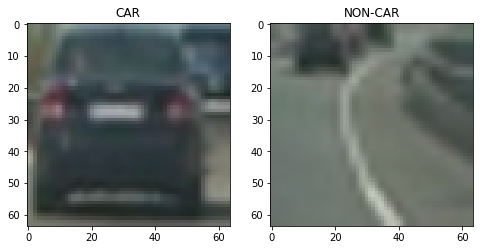

In [5]:
# example car image
plt.figure(figsize=(8, 8))

img_car = plt.imread("output_images/car.png")
plt.subplot(121)
plt.imshow(img_car)
plt.title("CAR")

# example non-car image
img_non_car = plt.imread("output_images/non_car.png")
plt.subplot(122)
plt.imshow(img_non_car)
plt.title("NON-CAR")

plt.show()

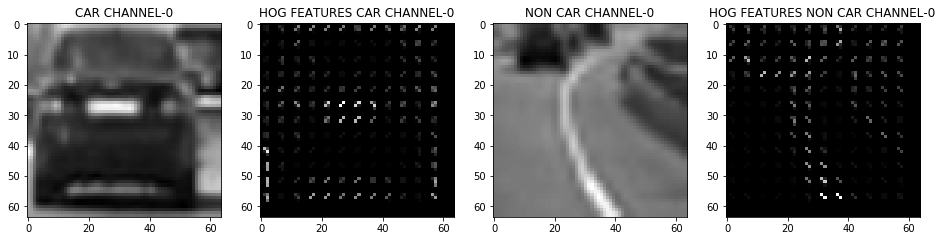

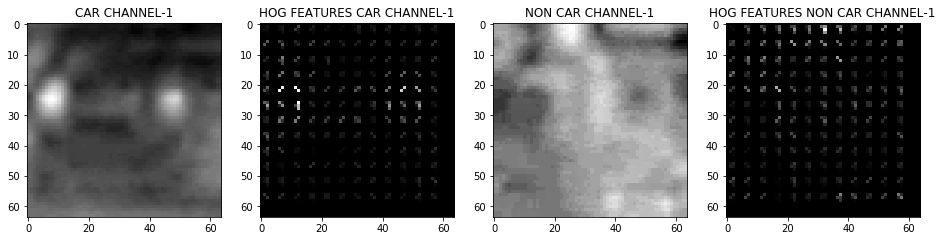

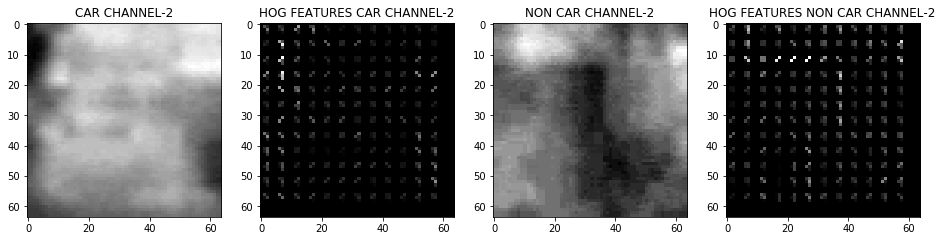

In [6]:
img_car_Cr_Cb = cv2.cvtColor(img_car, cv2.COLOR_RGB2YCrCb)
img_non_car_Cr_Cb = cv2.cvtColor(img_non_car, cv2.COLOR_RGB2YCrCb)
for ch in range(3):
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title("CAR CHANNEL-"+str(ch))
    img_car_ch = img_car_Cr_Cb[:,:,ch]
    plt.imshow(img_car_ch, cmap="gray")
    
    plt.subplot(1, 4, 2)
    plt.title("HOG FEATURES CAR CHANNEL-"+str(ch))
    _, img_car_ch_hog = get_hog_features(img_car_ch, 9, 5, 2, vis=True)
    plt.imshow(img_car_ch_hog, cmap="gray")
    
    plt.subplot(1, 4, 3)
    plt.title("NON CAR CHANNEL-"+str(ch))
    img_non_car_ch = img_non_car_Cr_Cb[:,:,ch]
    plt.imshow(img_non_car_ch, cmap="gray")
    
    plt.subplot(1, 4, 4)
    plt.title("HOG FEATURES NON CAR CHANNEL-"+str(ch))
    _, img_non_car_ch_hog = get_hog_features(img_non_car_ch, 9, 5, 2, vis=True)
    plt.imshow(img_non_car_ch_hog, cmap="gray")
    
plt.show()

In [7]:
# function to extract features from a list of images
# this function calls bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## TRAINING CLASSIFIER

In [8]:
# list of images
car_images = glob.glob('vehicles/vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/non-vehicles/*/*.png')

# extract car and non-car features
car_features = extract_features(car_images, 'YCrCb', hog_channel = 'ALL')
noncar_features = extract_features(noncar_images, 'YCrCb', hog_channel = 'ALL')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [9]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [10]:
# Split up data into randomized training and testing set
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=rand_state)

In [11]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)

test_score = svc.score(X_test, y_test)
print('My SVC score on test images: ', test_score)
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

My SVC score on test images:  0.987331081081
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  1.  1.  1.]


## FINDING CARS BY SLIDING WINDOWS

In [12]:
# function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox.append(((xbox_left, ytop_draw+ystart),
                             (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    
    return bbox

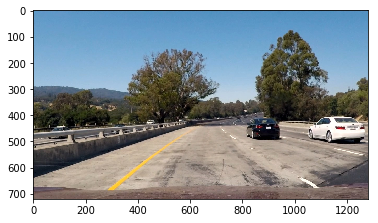

In [13]:
img = plt.imread('test_images/test1.jpg')
plt.imshow(img)

In [14]:
ystart = 400
ystop = 656
scales = (1.5, 1.8, 2.0)

In [15]:
def find_bbox(img):
    bbox = []
    for scale in scales:
        bbox1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, 
                      spatial_size=(32, 32), hist_bins=32)
        bbox = bbox + bbox1
    return bbox

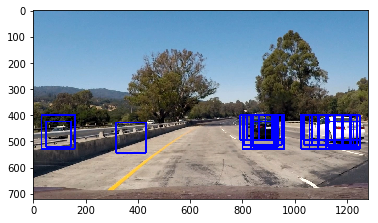

In [16]:
bbox = find_bbox(img)
for bx in bbox:
    cv2.rectangle(img, bx[0], bx[1], (0,0,255), 6)
plt.imshow(img)

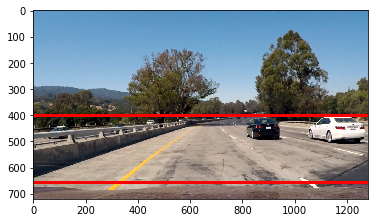

In [17]:
img = plt.imread('test_images/test1.jpg')
img = cv2.line(img, (0, ystart), (img.shape[1], ystart), (255, 0, 0), thickness=10)
img = cv2.line(img, (0, ystop), (img.shape[1], ystop), (255, 0, 0), thickness=10)
plt.imshow(img)

## HEATMAP IMPLEMENTATION

In [18]:
from scipy.ndimage.measurements import label

# hyper parameters for sliding window
ystart = 400
ystop = 656
scales = (1.5, 1.8, 2.0)

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [20]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [22]:
from scipy.ndimage.measurements import label
def get_labels(img, Q = None):
    bbox = find_bbox(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    if Q != None:
        if len(Q) == 10:
            Q.popleft()
        Q.append(heatmap)
        sum_heat = sum(Q)
        heatmap = apply_threshold(sum_heat, 5)
    labels = label(heatmap)
    return labels

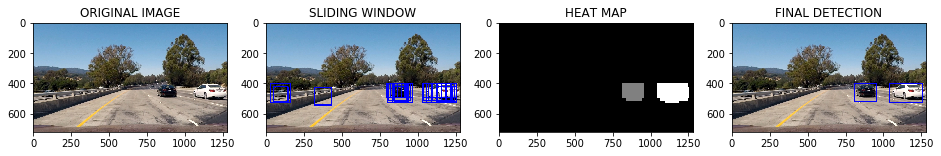

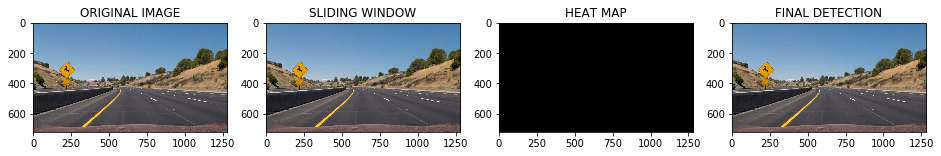

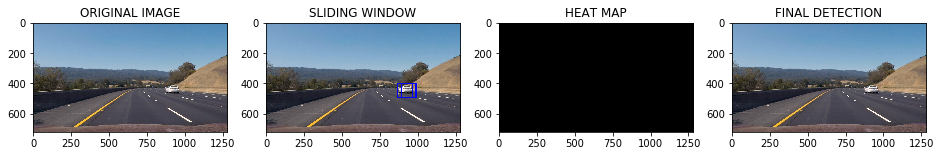

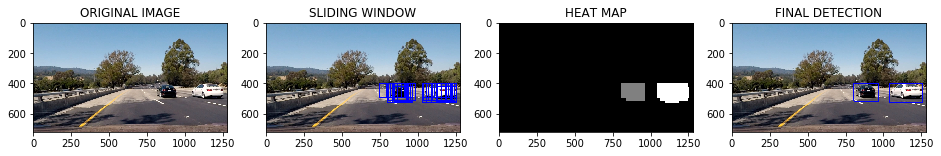

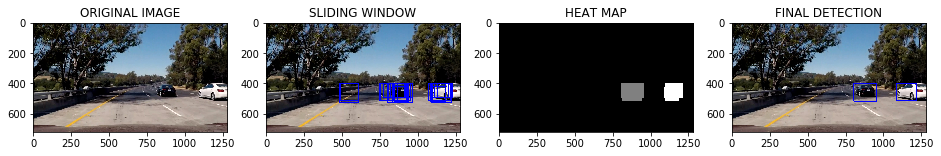

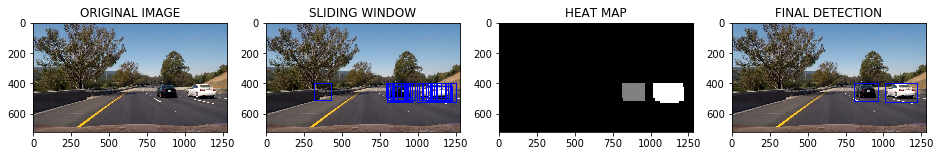

In [23]:
# read all test images
test_images = glob.glob('test_images/*.jpg')

for file in test_images:
    # print(file)
    # read image
    plt.figure(figsize=(16, 16))
    img = plt.imread(file)
    plt.subplot(1, 4, 1)
    plt.title("ORIGINAL IMAGE")
    plt.imshow(img)

    # print sliding windows output
    plt.subplot(1, 4, 2)
    img1 = np.copy(img)
    bbox = find_bbox(img1)
    for bx in bbox:
        cv2.rectangle(img1, bx[0], bx[1], (0,0,255), 6)
    plt.title("SLIDING WINDOW")
    plt.imshow(img1)

    # print heatmap
    plt.subplot(1, 4, 3)
    labels = get_labels(img)
    plt.title("HEAT MAP")
    plt.imshow(labels[0], cmap='gray')

    # print bounding box
    plt.subplot(1, 4, 4)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.title("FINAL DETECTION")
    plt.imshow(draw_img)
plt.show()

## VIDEO PIPELINE

In [24]:
from collections import deque
Q = deque(maxlen=10)
def processImage(img):
    labels = get_labels(img, Q)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [25]:
# process video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [14:14<00:00,  1.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 14min 14s
